<a href="https://colab.research.google.com/github/CharlotteY2003/MIT-Futuremakers/blob/main/7_28_Movie_Reviews_NLP_Multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import EarlyStopping
from tensorflow.keras import losses
import keras.preprocessing
from keras.optimizers import Adam
from keras.layers.experimental.preprocessing import TextVectorization

In [8]:
url = 'http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'

data = tf.keras.utils.get_file("stack_overflow_16k", url,
                               untar=True,cache_dir='.',
                               cache_subdir='')
data_dir = os.path.join(os.path.dirname(data),'bigquery-public-data')

In [11]:
train_dir = os.path.join('.', 'train')
os.listdir(train_dir)

['csharp', 'javascript', 'java', 'python']

In [12]:
sample_file = os.path.join(train_dir,'java/0.txt')
with open(sample_file) as f:
  print(f.read())

"how to download .msi file in blank i want to download .msi file using blank.  i have tried to download file using following code..printwriter out = null;.fileinputstream filetodownload = null;.bufferedreader bufferedreader = null;.try {.        out = response.getwriter();.        filetodownload = new fileinputstream(download_directory + file_name);.        bufferedreader = new bufferedreader(new inputstreamreader(filetodownload));..        //response.setcontenttype(""application/text"");.        //response.setcontenttype(""application/x-msi"");.        //response.setcontenttype(""application/msi"");.        //response.setcontenttype(""octet-stream"");.        response.setcontenttype(""application/octet-stream"");.        //response.setcontenttype(""application/x-7z-compressed"");.        //response.setcontenttype(""application/zip"");.        response.setheader(""content-disposition"",""attachment; filename="" +file_name );.        response.setcontentlength(filetodownload.available())

In [13]:
batch_size = 32
seed = 42
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory('./train', batch_size=batch_size,
                                           validation_split=.2,subset='training',
                                           seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [14]:
for text_batch,label_batch in raw_train_ds.take(1):
  for i in range(3):
    print('Review', text_batch.numpy()[i])
    print('Label', label_batch.numpy()[i])

Review b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constru

In [15]:
print('Label 0 corresponds to: ', raw_train_ds.class_names[0])
print('Label 1 corresponds to: ', raw_train_ds.class_names[1])
print('Label 2 corresponds to: ', raw_train_ds.class_names[2])
print('Label 3 corresponds to: ', raw_train_ds.class_names[3])

Label 0 corresponds to:  csharp
Label 1 corresponds to:  java
Label 2 corresponds to:  javascript
Label 3 corresponds to:  python


In [16]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory('./train', batch_size=batch_size,
                                           validation_split=.2,subset='validation',
                                           seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [17]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory('./test', batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [18]:
def custom_standardize(input_text):
  lowercase = tf.strings.lower(input_text)
  stripped_html = tf.strings.regex_replace(lowercase,'<br />', ' ')
  return tf.strings.regex_replace(stripped_html,'[%s]' % re.escape(string.punctuation),'')

In [19]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardize,
    max_tokens = max_features,
    output_mode = 'int', #Assign unique int indices for each token
    output_sequence_length=sequence_length #make sequences to output sequence length values
)

In [20]:
train_text = raw_train_ds.map(lambda x, y: x) #Make text only dataset without labels
vectorize_layer.adapt(train_text)

In [21]:
def vectorize_text(text,label):
  text = tf.expand_dims(text,-1)
  return vectorize_layer(text), label

In [22]:
text_batch,label_batch = next(iter(raw_train_ds))
first_review,first_label = text_batch[0], label_batch[0]
print('Review: ', first_review)
print('Label: ', raw_train_ds.class_names[first_label])
print('Vectorized review: ', vectorize_text(first_review,first_label))

Review:  tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of ex

In [23]:
print('1287 ----->', vectorize_layer.get_vocabulary()[1287])

1287 -----> scissors


In [24]:
print('Vocab size: {}'.format(len(vectorize_layer.get_vocabulary())))

Vocab size: 10000


In [25]:
train_ds = raw_train_ds.map(vectorize_text) #isn't this a function?
test_ds = raw_test_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
embedding_dim = 16

In [28]:
model = Sequential([
                    Embedding(max_features+1,embedding_dim),
                    Dropout(.2),
                    GlobalAveragePooling1D(),
                    Dropout(.2),
                    Dense(4)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 68        
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(optimizer = 'adam', loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
es = EarlyStopping(min_delta=.01,patience=2,mode='min',restore_best_weights=True)
history = model.fit(train_ds,validation_data=val_ds,epochs=10, callbacks=[es])

In [32]:
loss, accuracy = model.evaluate(test_ds)
print('Loss: ', loss)
print('Accuracy: ', accuracy)

250/250 [==============================] - 3s 11ms/step - loss: 0.8646 - accuracy: 0.7379
Loss:  0.8646071553230286
Accuracy:  0.7378749847412109


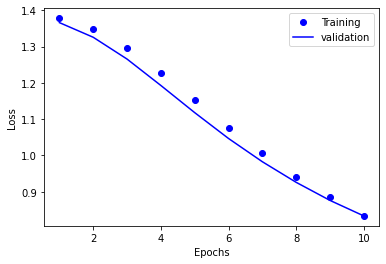

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training') #bo = blue dot
plt.plot(epochs, val_loss, 'b', label="validation") #b = blue line
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

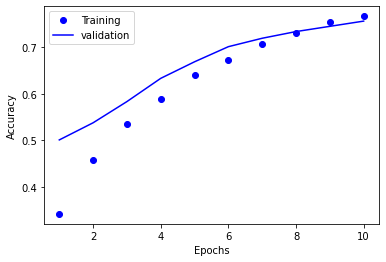

In [34]:
plt.plot(epochs, acc, 'bo', label='Training') #bo = blue dot
plt.plot(epochs, val_acc, 'b', label="validation") #b = blue line
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [35]:
#can process raw text strings
export_model = Sequential([
                           vectorize_layer,
                           model,
                           Activation('softmax')
])
export_model.compile(optimizer = 'adam', loss=losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [36]:
loss,accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 10s 11ms/step - loss: 0.8689 - accuracy: 0.7315
0.7378749847412109


In [48]:
examples = [
            "for(int i=0; i< 3; i++)"
]

index = export_model.predict_classes(examples)
index = index[0]
print('Prediction is: ', raw_test_ds.class_names[index])

Prediction is:  javascript


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
